# Lab 8/9 Report: 
## Classify Gravitational Waves

### Name: Travis Hand, Arun Iyer

In [48]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.distributions import Categorical
import h5py
import tqdm
import scipy
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, random_split
from scipy.signal import butter, sosfiltfilt, welch

## Prepare Data

In [49]:
class GravitationalWaveDataset(Dataset):
    def __init__(self, file_path, label_map, transform=None):
        self.data = []
        self.labels = []
        self.transform = transform
        self.label_map = label_map

        with h5py.File(file_path, 'r') as f:
            for label, idx in label_map.items():
                dataset = f[label][:]
                self.data.append(dataset)  # shape: (2048, 2, 4096)
                self.labels += [idx] * len(dataset)

        self.data = np.concatenate(self.data)  # shape: (8192, 2, 4096) for 4 classes
        self.labels = np.array(self.labels)

    def __len__(self):
        return len(self.data)


    def __getitem__(self, idx):
        x = self.data[idx]
        y = self.labels[idx]

        # Channel-wise normalization: per sensor (L1 and H1)
        for i in range(x.shape[0]):
            x[i] = (x[i] - x[i].mean()) / (x[i].std() + 1e-8)

        if self.transform:
            x = self.transform(x)

        x = torch.tensor(x, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.long)
        return x, y

class GravitationalWaveDataset2(Dataset):
    def __init__(self, file_path, label_map, transform=None, fs=4096, band=(20, 500)):
        self.data = []
        self.labels = []
        self.transform = transform
        self.label_map = label_map
        self.fs = fs
        self.band = band
        self.eps = 1e-8

        with h5py.File(file_path, 'r') as f:
            for label, idx in label_map.items():
                dataset = f[label][:]
                self.data.append(dataset)  # shape: (2048, 2, 4096)
                self.labels += [idx] * len(dataset)

        self.data = np.concatenate(self.data)  # shape: (8192, 2, 4096)
        self.labels = np.array(self.labels)

    def __len__(self):
        return len(self.data)

    def bandpass_filter(self, signal):
        sos = butter(N=4, Wn=[self.band[0], self.band[1]], btype='band', fs=self.fs, output='sos')
        return sosfiltfilt(sos, signal)

    def whiten(self, signal):
        freqs, psd = welch(signal, fs=self.fs, nperseg=1024)
        interp_psd = np.interp(np.fft.rfftfreq(len(signal), 1/self.fs), freqs, psd)
        signal_fft = np.fft.rfft(signal)
        white_fft = signal_fft / (np.sqrt(interp_psd) + self.eps)
        white_signal = np.fft.irfft(white_fft, n=len(signal))
        return white_signal

    def __getitem__(self, idx):
        x = self.data[idx]  # shape: [2, 4096]
        y = self.labels[idx]

        # Preprocess each channel (L1 and H1)
        for i in range(x.shape[0]):
            x[i] = self.bandpass_filter(x[i])
            x[i] = self.whiten(x[i])
            x[i] = (x[i] - x[i].mean()) / (x[i].std() + self.eps)

            plt.plot(x[0])  # L1
            plt.plot(x[1])  # H1
            plt.title("Preprocessed Sample (L1 & H1)")
            plt.show()


        if self.transform:
            x = self.transform(x)

        x = torch.tensor(x, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.long)
        return x, y

label_map = {
    'background': 0,
    'binaryblackhole': 1,
    'ccsn': 2,
    'glitch': 3
}

dataset = GravitationalWaveDataset2('./GW2_Andy.h5', label_map)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)



## Define Model

In [50]:
class GWClassifier(nn.Module):

    def __init__(self):
        super(GWClassifier, self).__init__()

        # CNN: Feature extraction from raw 1D signals (per sensor)
        self.cnn = nn.Sequential(
            nn.Conv1d(2, 16, kernel_size=64, stride=2),
            nn.ReLU(),
            nn.MaxPool1d(4),
            nn.Conv1d(16, 32, kernel_size=32),
            nn.ReLU(),
            nn.MaxPool1d(4)
        )
        # Get explanation for each part of the model from chat
        
        # GRU: Temporal modeling of CNN-extracted features
        self.gru = nn.GRU(input_size=32, hidden_size=64, batch_first=True, bidirectional=True)

        # Final classification
        self.fc = nn.Linear(64 * 2, 4)

    def forward(self, x):
        # x: [batch_size, 2, 4096]
        x = self.cnn(x)  # -> [batch_size, 32, reduced_seq_len]
        x = x.permute(0, 2, 1)  # -> [batch_size, seq_len, features]
        _, h_n = self.gru(x)  # h_n: [2, batch, 64]
        h_n = h_n.permute(1, 0, 2).reshape(x.size(0), -1)  # -> [batch, 128]
        return self.fc(h_n)  # -> [batch, 4]


In [51]:
class InceptionBlock1D(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(InceptionBlock1D, self).__init__()
        self.branch1 = nn.Conv1d(in_channels, out_channels, kernel_size=1, padding=0)

        self.branch3 = nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1)

        self.branch5 = nn.Conv1d(in_channels, out_channels, kernel_size=5, padding=2)

        self.pool = nn.MaxPool1d(kernel_size=3, stride=1, padding=1)
        self.branch_pool = nn.Conv1d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        b1 = self.branch1(x)
        b3 = self.branch3(x)
        b5 = self.branch5(x)
        bp = self.branch_pool(self.pool(x))
        return torch.cat([b1, b3, b5, bp], dim=1)  # shape: [B, 4*out_channels, L]
    

class GWClassifier2(nn.Module):

    def __init__(self, in_channels=2, base_channels=16, num_classes=4):
        super(GWClassifier2, self).__init__()
        self.incept1 = InceptionBlock1D(in_channels, base_channels)  # output: [B, 64, 4096]
        self.bn1 = nn.BatchNorm1d(4 * base_channels)
        self.incept2 = InceptionBlock1D(4 * base_channels, base_channels)  # output: [B, 64, 4096]
        self.bn2 = nn.BatchNorm1d(4 * base_channels)
        self.pool = nn.AdaptiveAvgPool1d(1)  # shape: [B, 64, 1]
        self.fc = nn.Linear(4 * base_channels, num_classes)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.bn1(self.incept1(x))
        x = F.relu(x)
        x = self.bn2(self.incept2(x))
        x = F.relu(x)
        x = self.pool(x).squeeze(-1)  # shape: [B, 64]
        x = self.dropout(x)
        x = self.fc(x)
        return x

## Define Hyperparameters

In [52]:
# Fix random seed
torch.manual_seed(25)

# Define RNN network
model = GWClassifier2()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# add .cuda() for GPU acceleration


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GWClassifier2().to(device)

## Identify Tracked Values

In [53]:
# Tracking training loss per each input/target sequence fwd/bwd pass
training_loss = []
validation_accuracy = []

## Train Model

  0%|          | 0/20 [00:00<?, ?it/s]

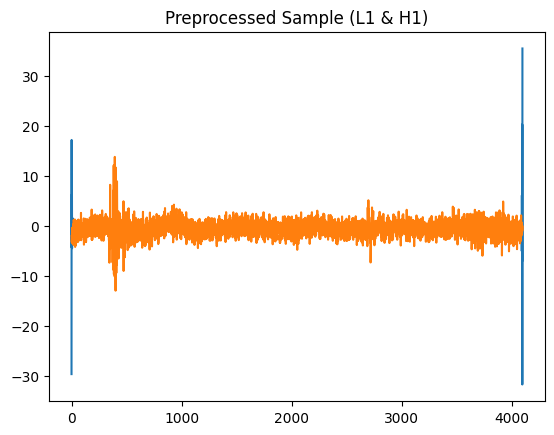

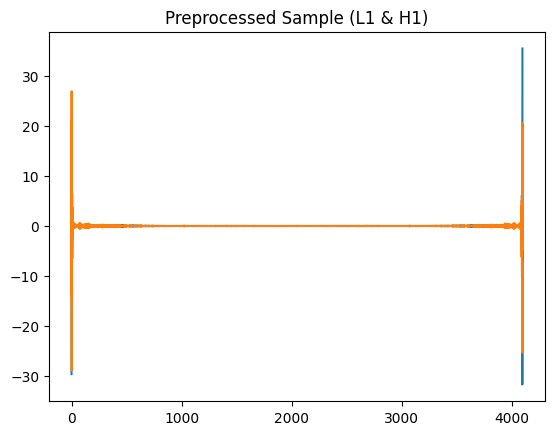

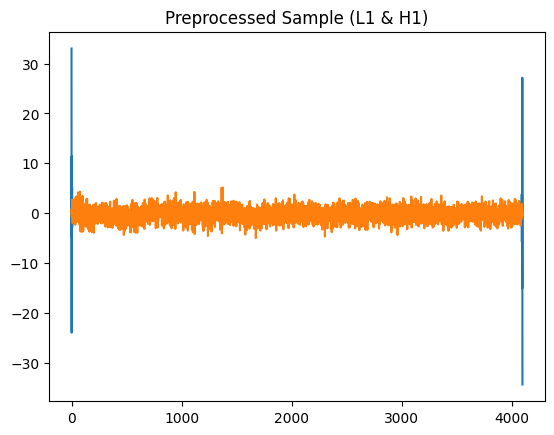

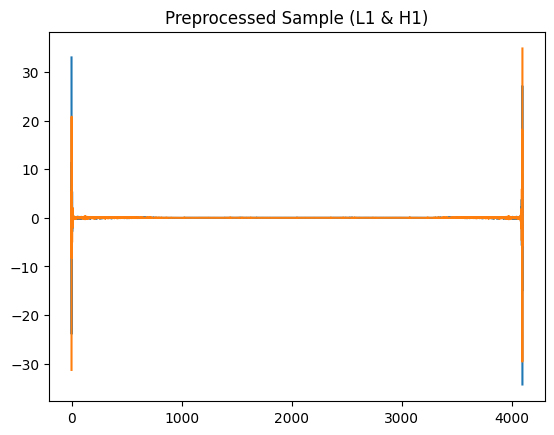

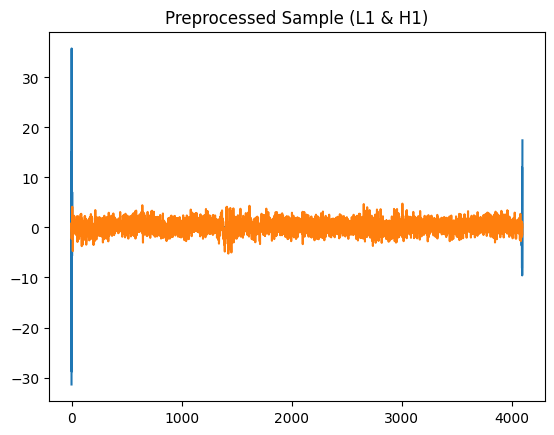

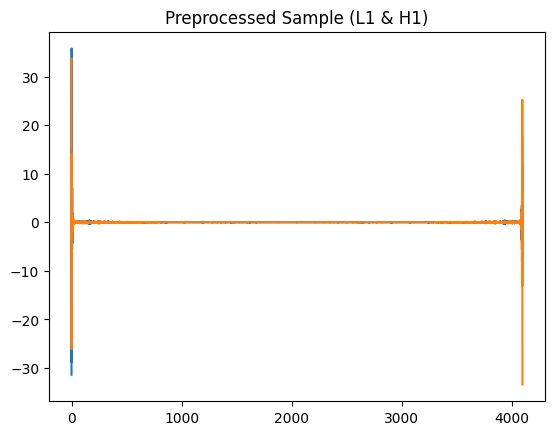

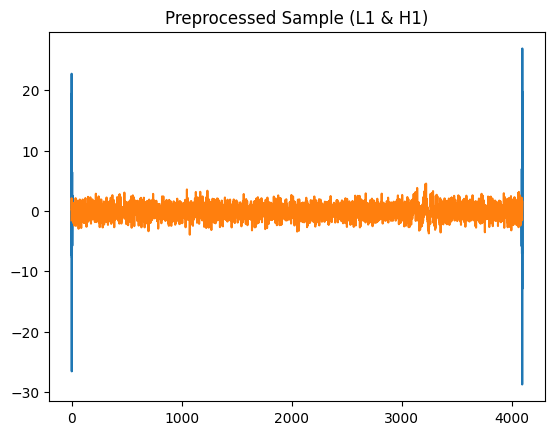

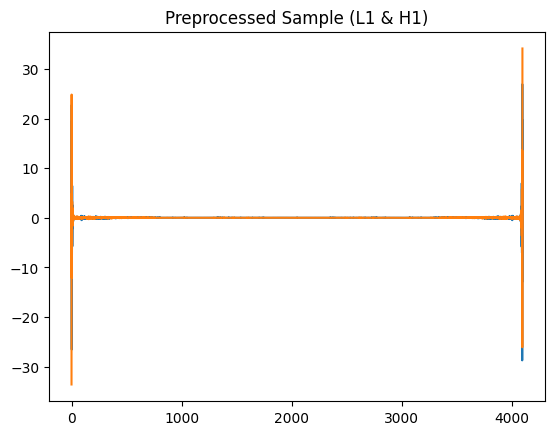

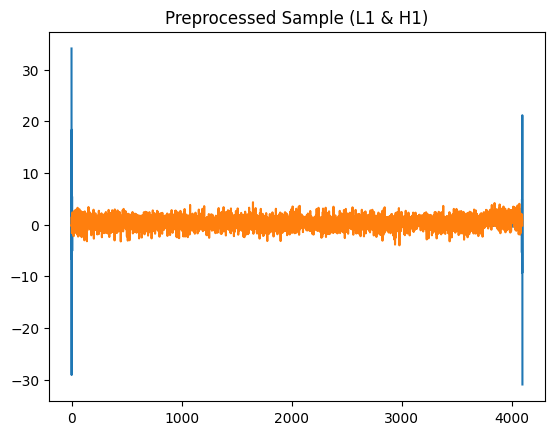

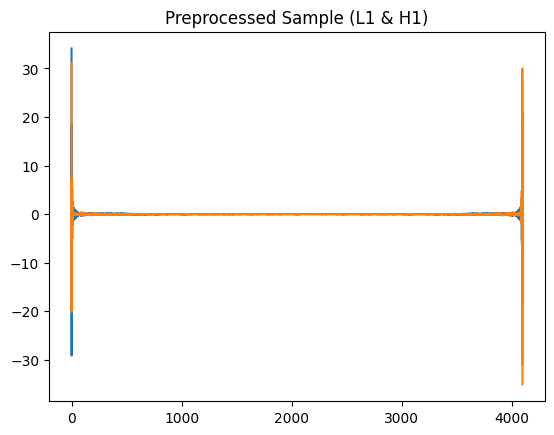

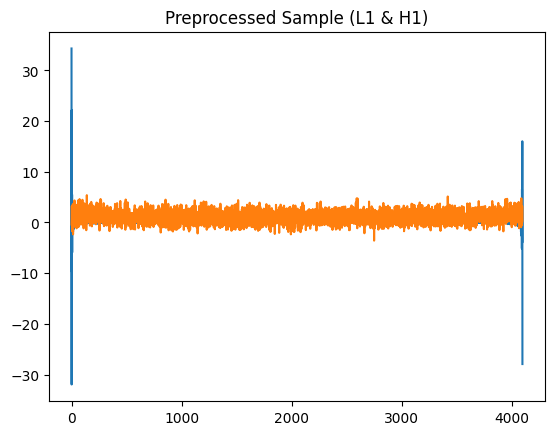

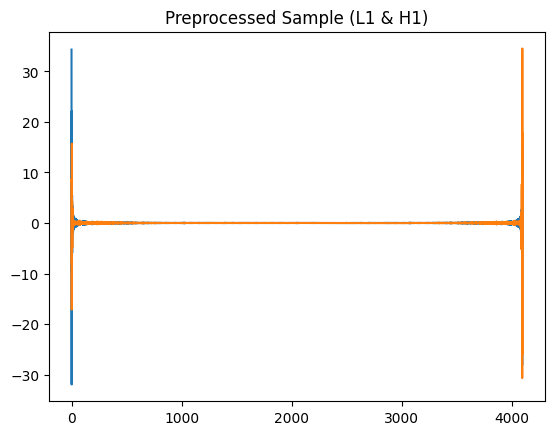

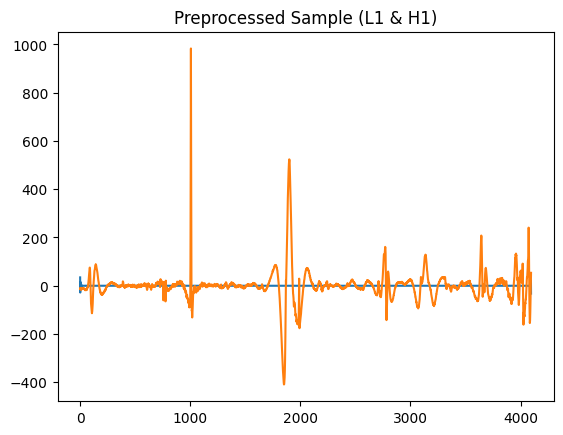

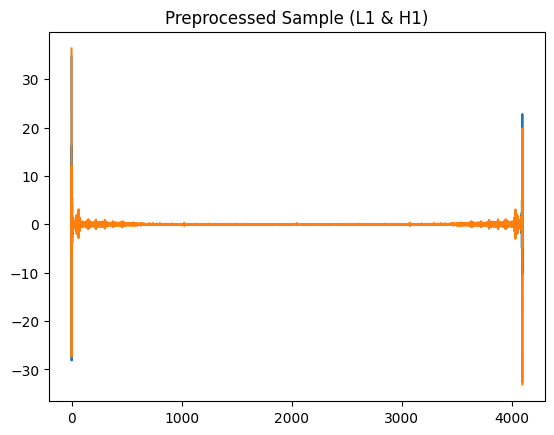

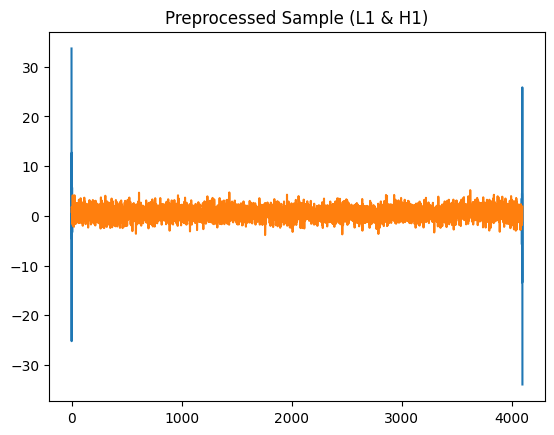

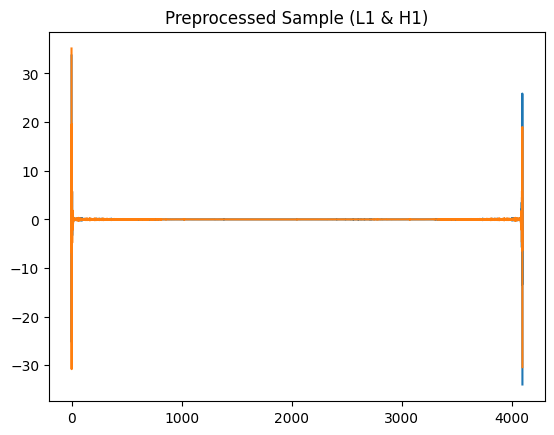

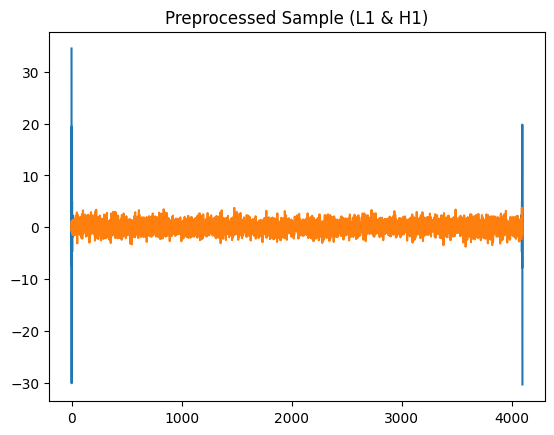

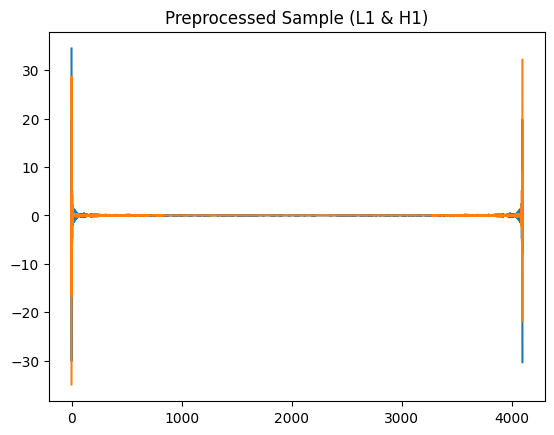

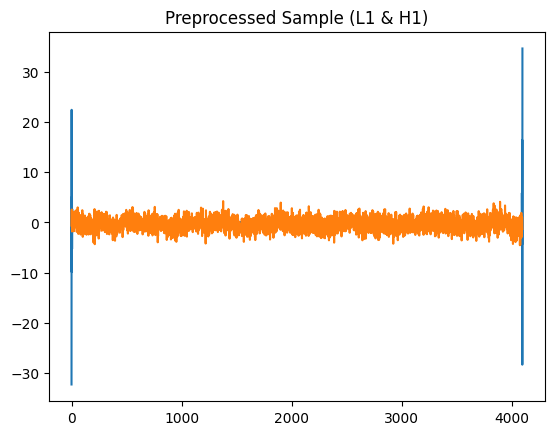

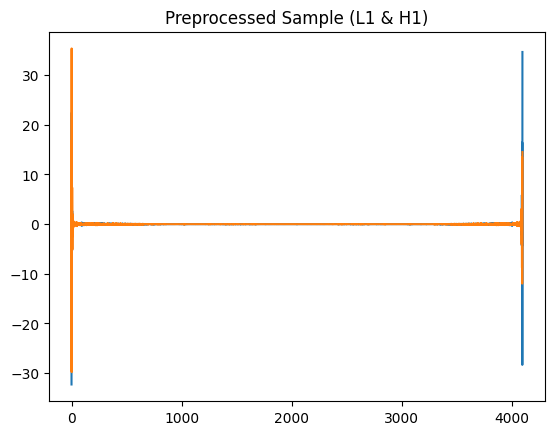

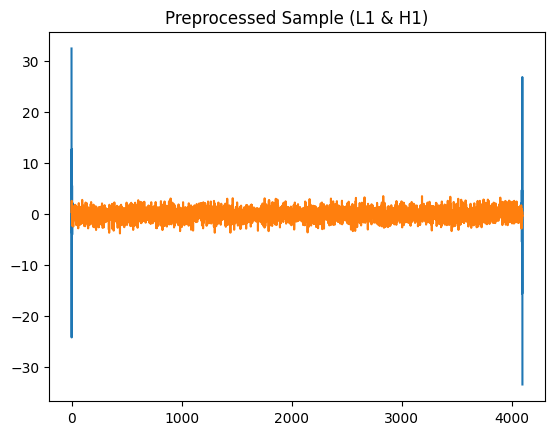

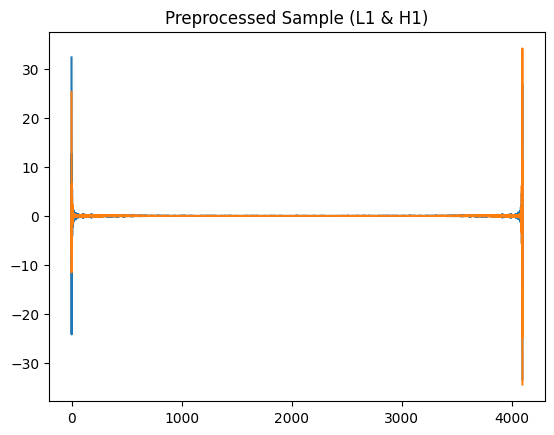

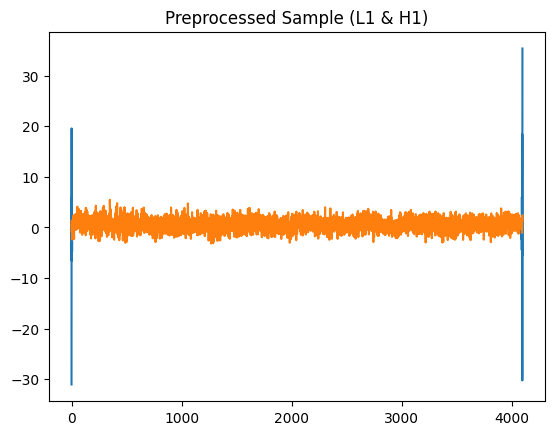

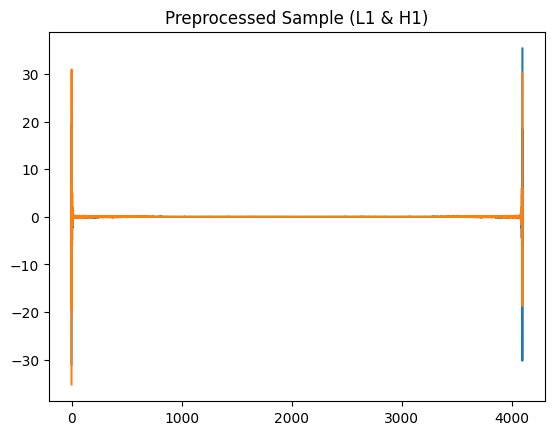

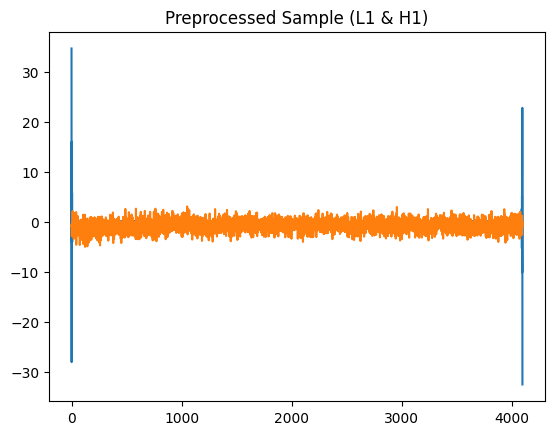

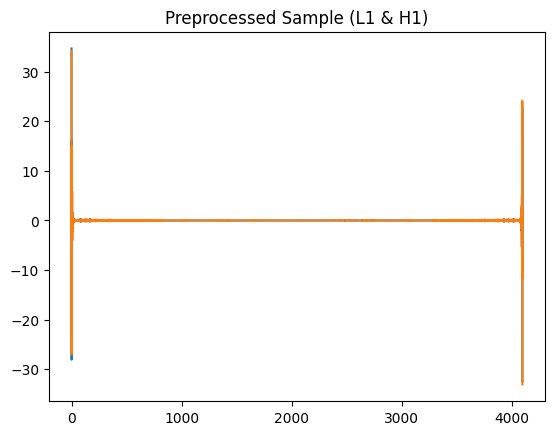

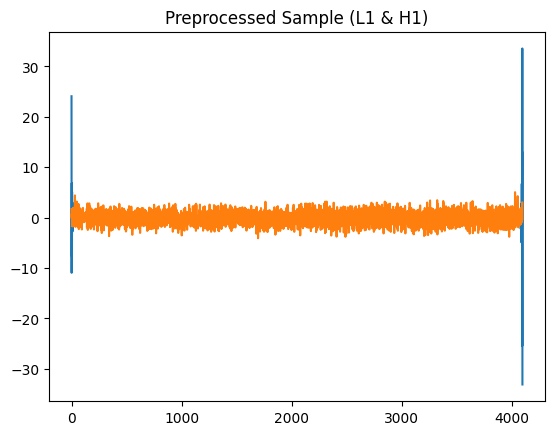

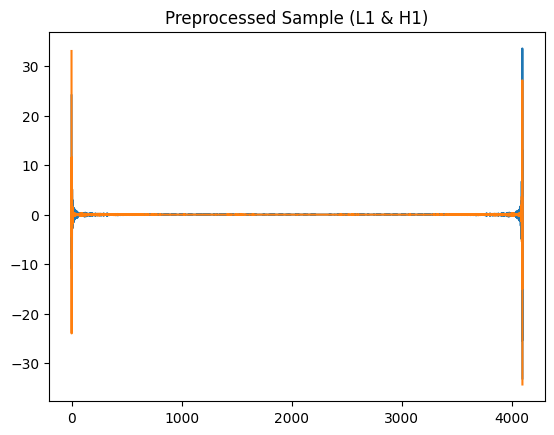

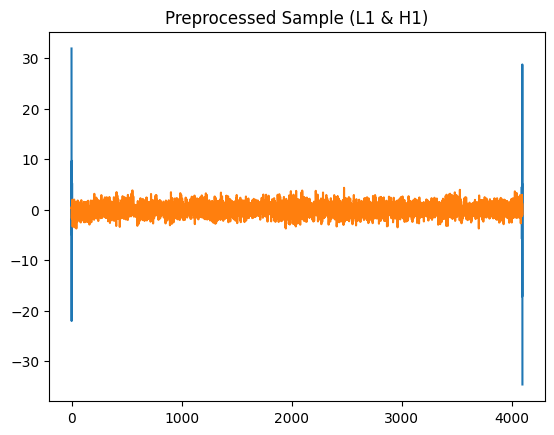

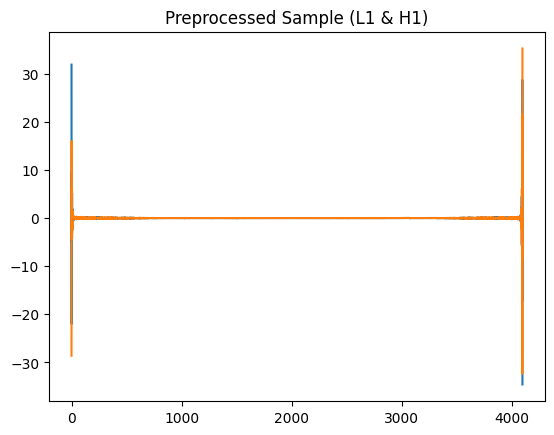

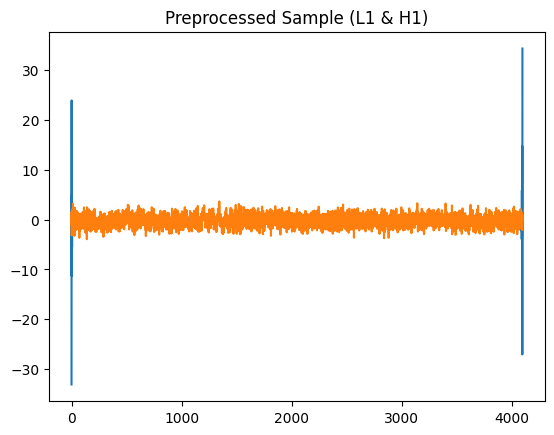

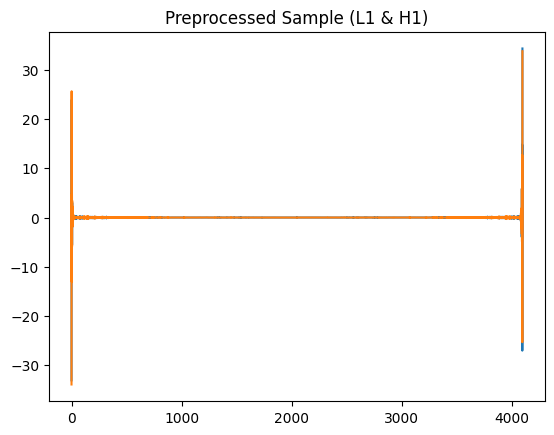

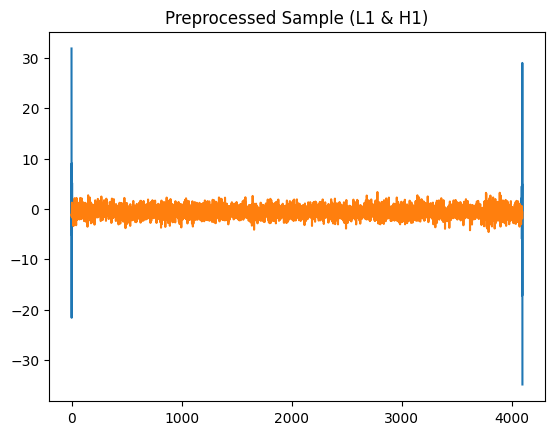

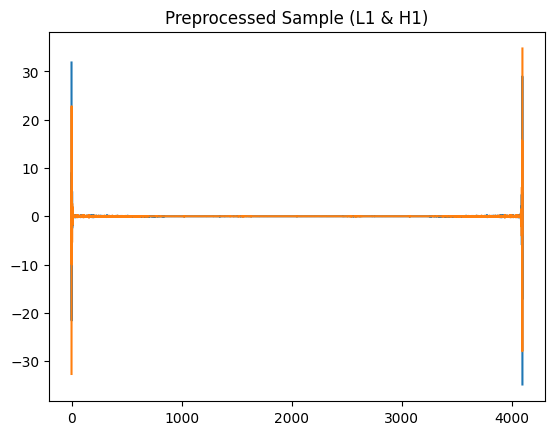

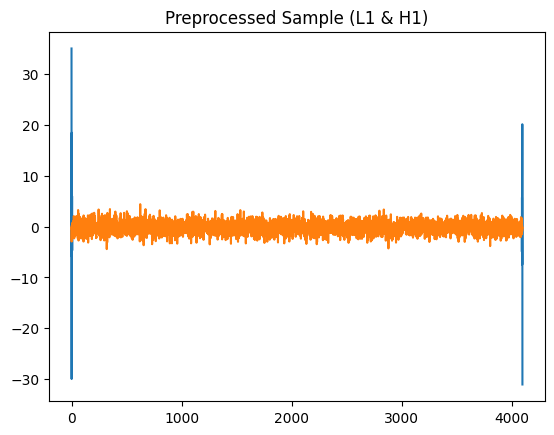

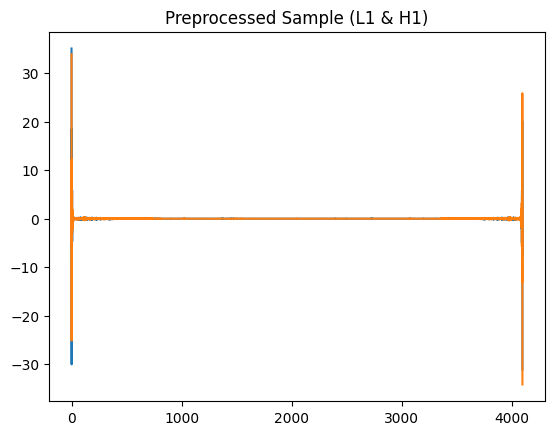

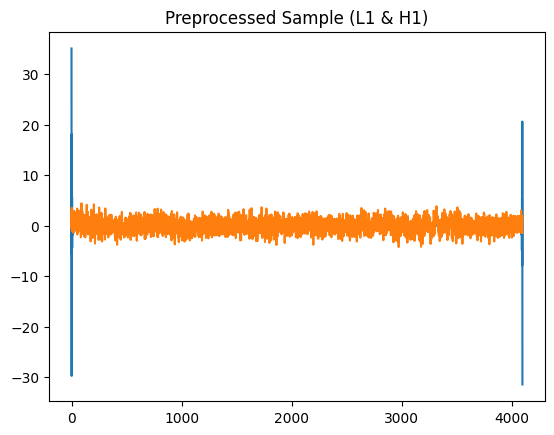

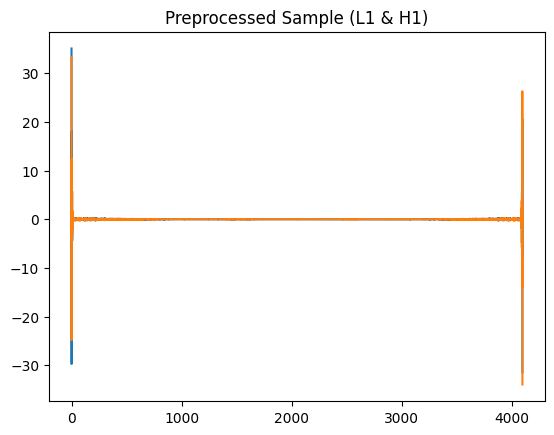

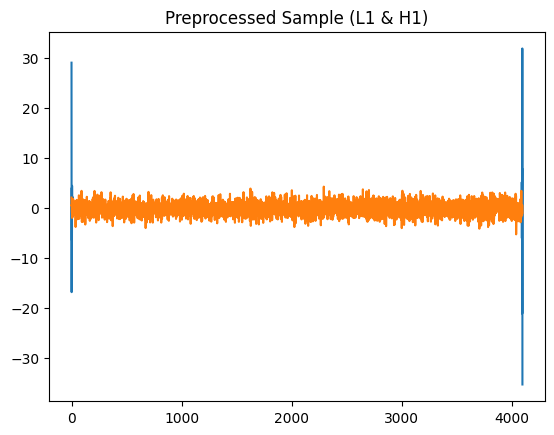

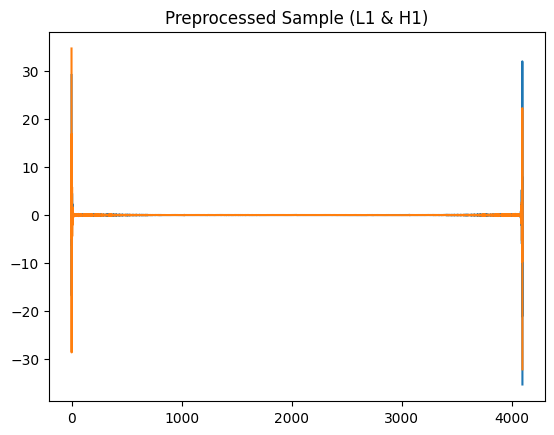

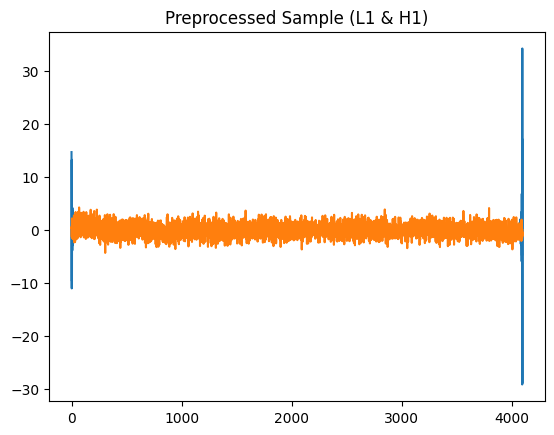

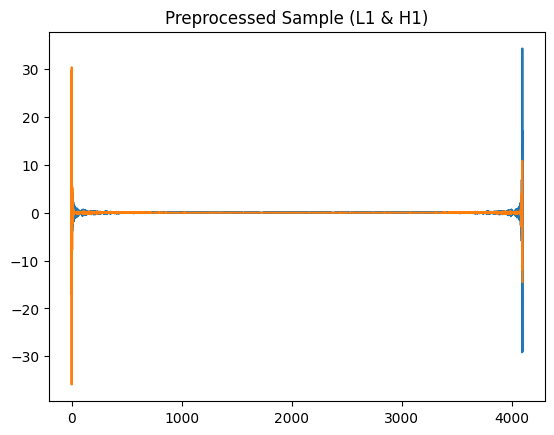

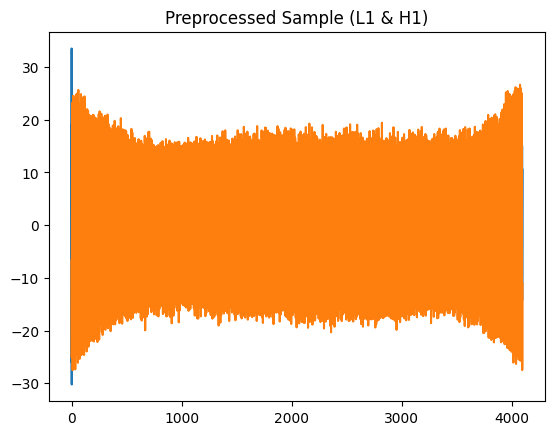

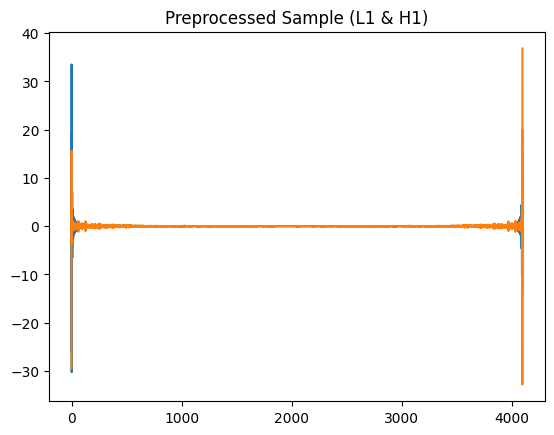

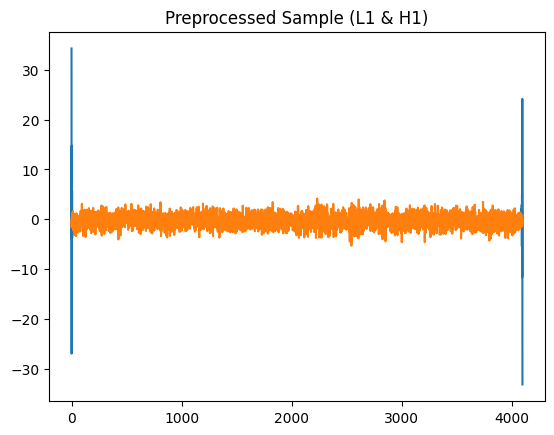

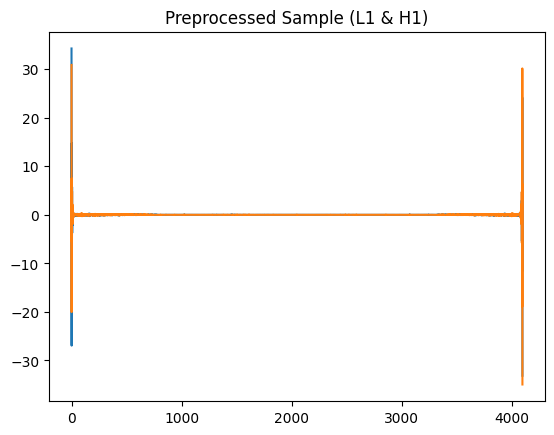

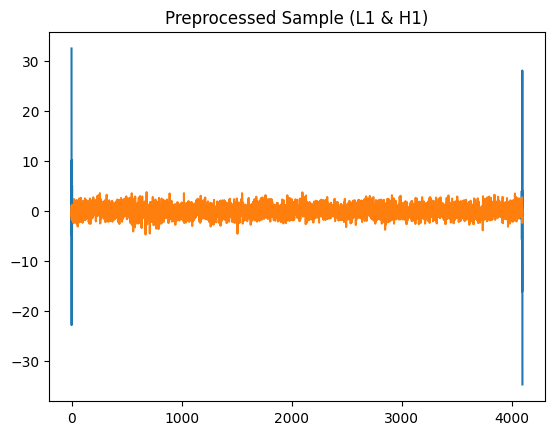

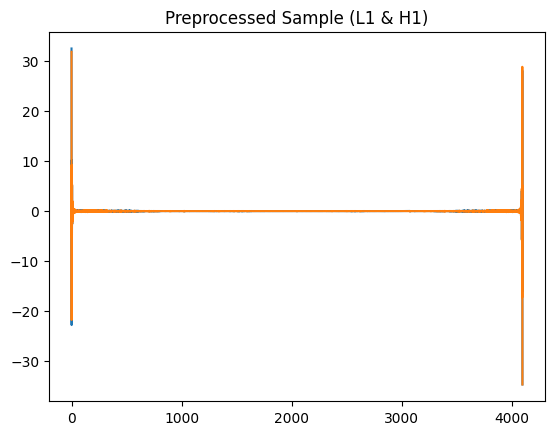

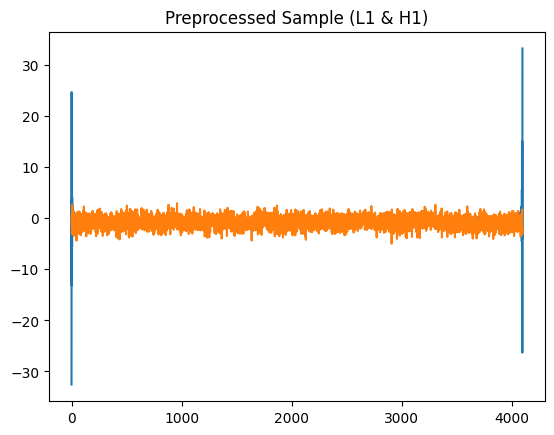

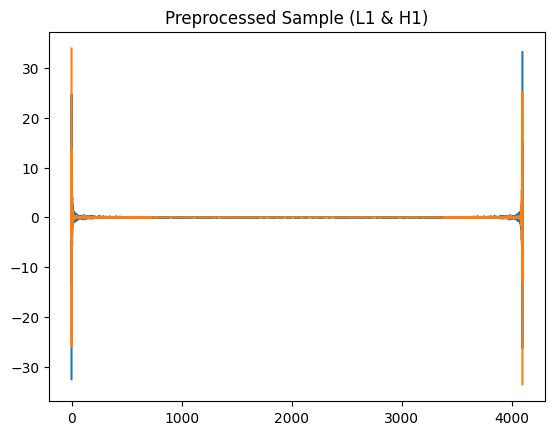

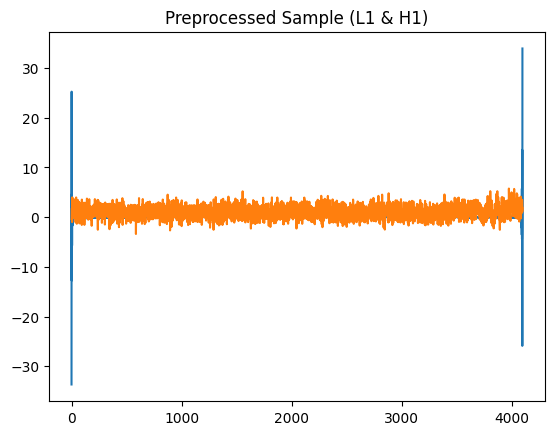

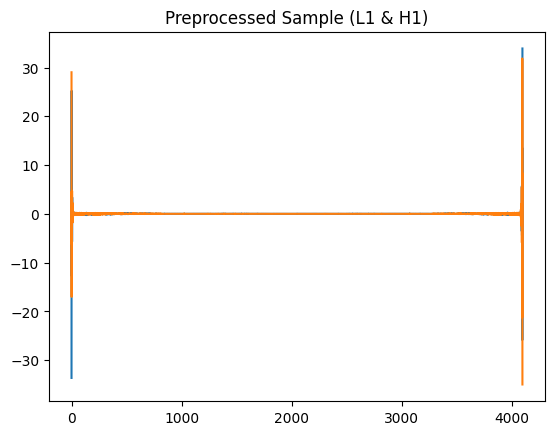

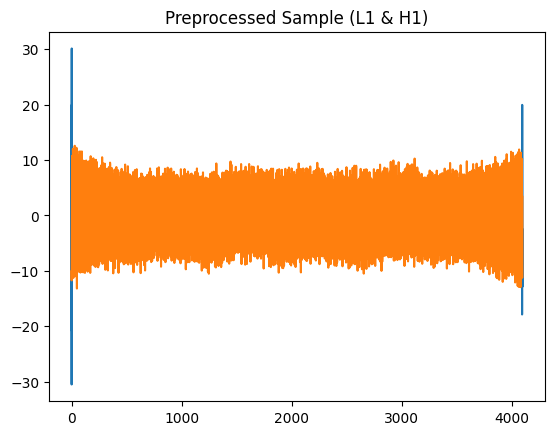

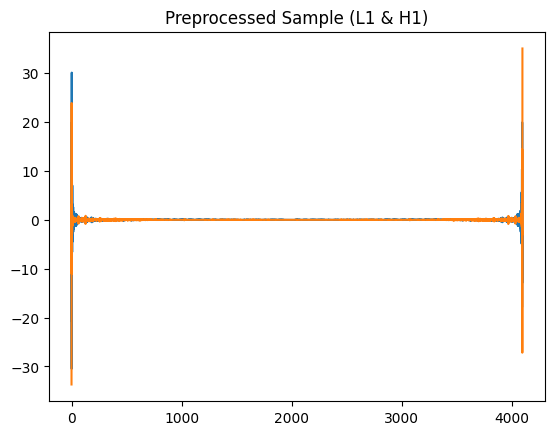

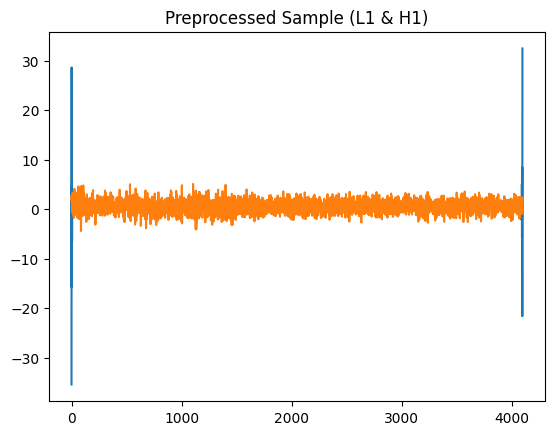

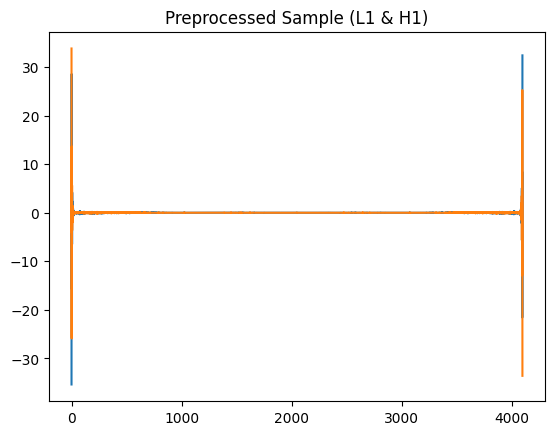

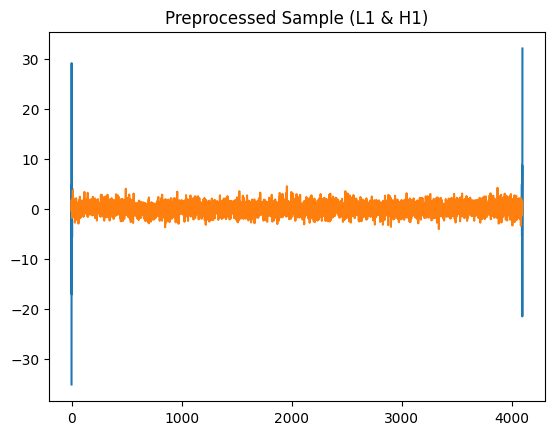

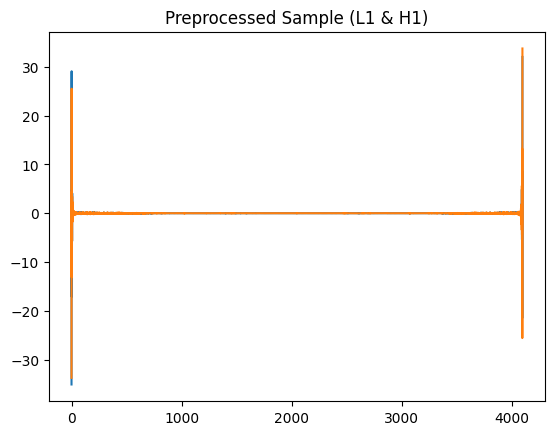

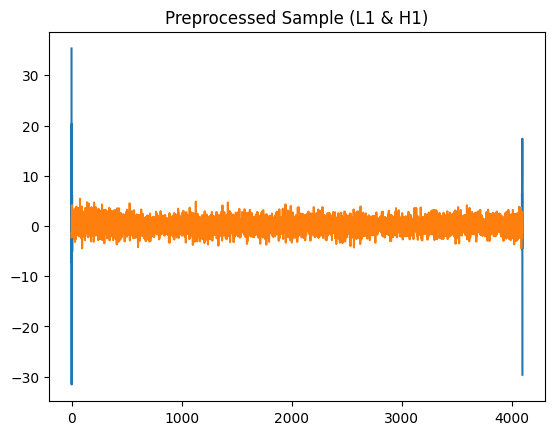

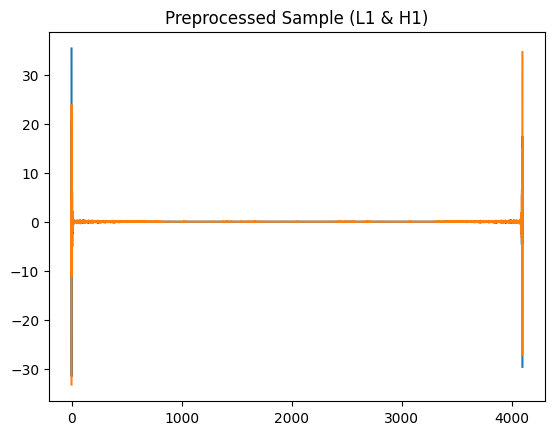

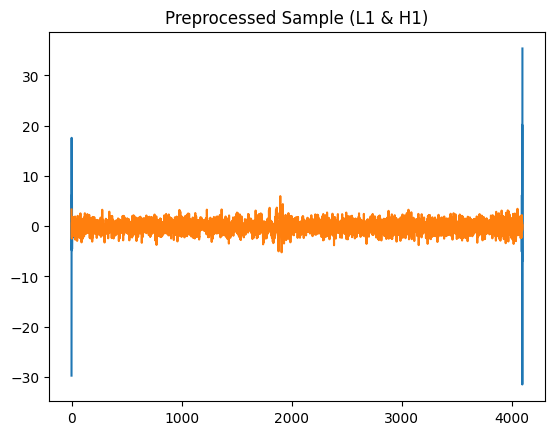

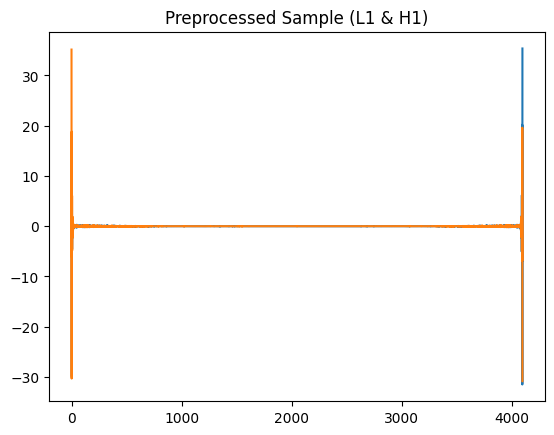

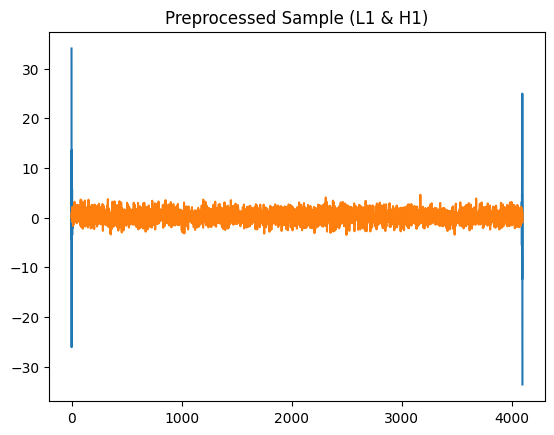

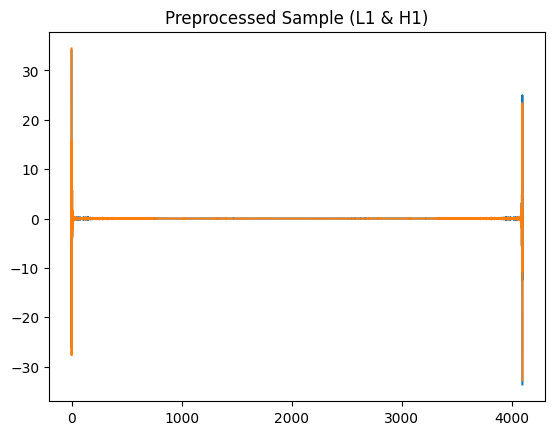

  0%|          | 0/20 [00:03<?, ?it/s]


KeyboardInterrupt: 

In [54]:
num_epochs = 20

for epoch in tqdm.trange(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()

    train_loss = running_loss / len(train_loader.dataset)
    train_acc = correct / len(train_loader.dataset)

    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()

    val_loss /= len(val_loader.dataset)
    val_acc = val_correct / len(val_loader.dataset)

    print(f"Epoch {epoch+1}/{num_epochs} - "
          f"Train Loss: {train_loss:.4f} - Train Acc: {train_acc:.4f} - "
          f"Val Loss: {val_loss:.4f} - Val Acc: {val_acc:.4f}")


## Visualize & Evaluate Model

In [ ]:
# Import seaborn for prettier plot
import seaborn as sns

sns.set(style = 'whitegrid', font_scale = 2.5)

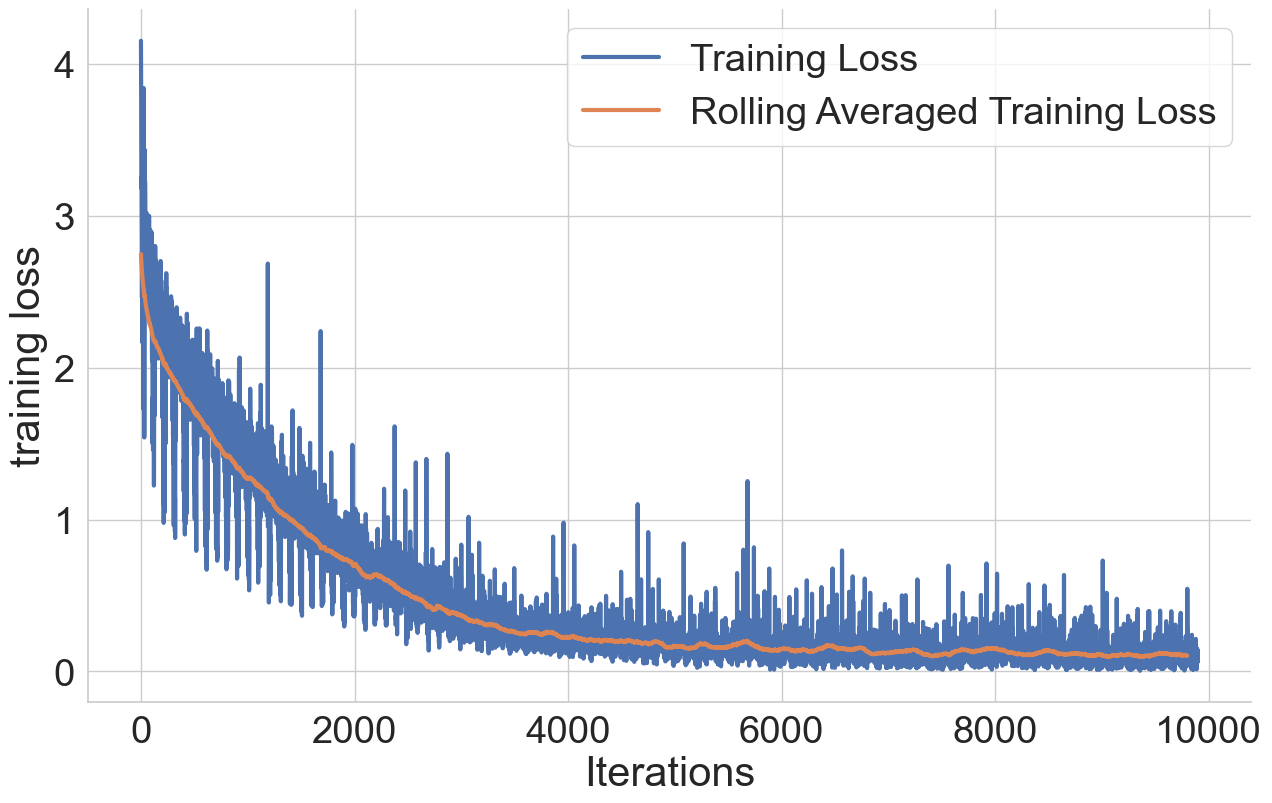

In [ ]:
# Plot the training loss and rolling mean training loss with respect to iterations
# Feel free to change the window size
plt.figure(figsize = (15, 9))

plt.plot(training_loss, linewidth = 3, label = 'Training Loss')
plt.plot(np.convolve(training_loss, np.ones(100), 'valid') / 100, 
         linewidth = 3, label = 'Rolling Averaged Training Loss')
plt.ylabel("training loss")
plt.xlabel("Iterations")
plt.legend()
sns.despine()